In [1]:
import ray
GPU_UTILIZATION = 0.0
ray.init(num_gpus=GPU_UTILIZATION)

2023-11-25 00:06:32,853	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-11-25 00:06:34,699	INFO worker.py:1664 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.10.13
Ray version:,2.8.0
Dashboard:,http://127.0.0.1:8265


In [29]:
import gymnasium as gym
from ray.tune.registry import register_env
from ray.rllib.env.base_env import BaseEnv

class custom_env(gym.Env):
    def __init__(self,config):
        gym.Env.__init__(self)
        self.env = gym.make('CartPole-v1')
        self.observation_space = self.env.observation_space
        self.action_space = self.env.action_space

    def reset(self,*, seed=None, options=None):
        obs,info = self.env.reset()
        return obs,info

    def step(self, action):
        observation, reward, terminated, truncated,done = self.env.step(action)
        return observation, reward, terminated, truncated,done 

def env_creator(config):
    if len(config) == 0:
        config = {}
    return custom_env(config=config)

register_env("my_env", env_creator)

In [30]:
from ray.rllib.algorithms.ppo import PPOConfig

config = PPOConfig().training(gamma=0.9, lr=0.0001, train_batch_size=512, sgd_minibatch_size=256)
config = config.resources(num_gpus=GPU_UTILIZATION, num_learner_workers=1, num_gpus_per_worker=0, num_gpus_per_learner_worker=GPU_UTILIZATION)
config = config.rollouts(num_rollout_workers=4,create_env_on_local_worker=True)

algo = config.build(env="my_env")  

(RolloutWorker pid=16766) 2023-11-25 00:19:01,070	WARNING __init__.py:10 -- PG has/have been moved to `rllib_contrib` and will no longer be maintained by the RLlib team. You can still use it/them normally inside RLlib util Ray 2.8, but from Ray 2.9 on, all `rllib_contrib` algorithms will no longer be part of the core repo, and will therefore have to be installed separately with pinned dependencies for e.g. ray[rllib] and other packages! See https://github.com/ray-project/ray/tree/master/rllib_contrib#rllib-contrib for more information on the RLlib contrib effort.
2023-11-25 00:19:01,163	WARNING env.py:162 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=16764) 2023-11-25 00:19:01,110	WARNING env.py:162 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
2023-11-25 00:19:01,207	INFO util.py

(_WrappedExecutable pid=16908) Setting up process group for: env:// [rank=0, world_size=1]


In [31]:
from time import time 
init_eval = algo.evaluate()

t1 = time()
for i in range(32):
    print(i,end='\r')
    algo.train()

print(time() - t1)
post_eval = algo.evaluate()

20.645001888275146


In [32]:
print('Mean reward per episode')
print('Before training: ',init_eval['evaluation']['episode_reward_mean'])
print('After training: ',post_eval['evaluation']['episode_reward_mean'])

Mean reward per episode
Before training:  23.01818181818182
After training:  214.2


In [33]:
import gymnasium as gym 
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [34]:
env = gym.make('CartPole-v1', render_mode="rgb_array")
model = algo.get_policy().model

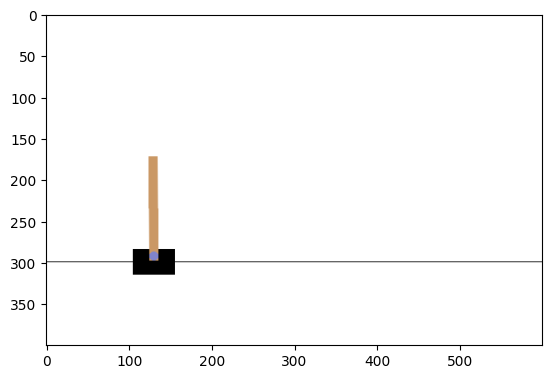

In [35]:
next_state = env.reset()[0]
num_steps = 120

for step in range(num_steps):
    with torch.no_grad():
        action = model({'obs': torch.Tensor(next_state.reshape([1,4]))})['action_dist_inputs'].argmax().item()

    next_state, reward, done = env.step(action)[:3]

    clear_output(wait=True)
    plt.imshow(env.render())
    plt.show()

    print(step, end='\r')
    
    if done:
        print(f"Episode finished after {step+1} steps")
        break

In [18]:
env.reset()

(array([ 0.01834047,  0.03332799, -0.0126188 ,  0.03240417], dtype=float32),
 {})